In [1]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
vir = get_cmap("viridis")

from statsmodels.stats.power import TTestIndPower

power_calc = TTestIndPower()

def get_power(n, es): return power_calc.solve_power(nobs1 = n, effect_size = es, alpha = 0.05)

#### Navigating the Effect Size

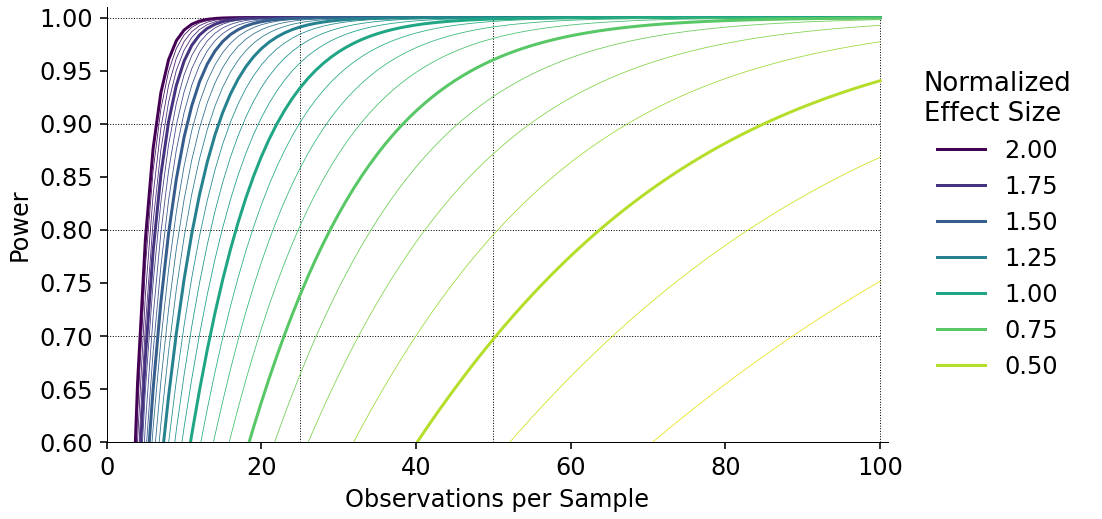

In [2]:
fig, ax = plt.subplots(figsize = (7, 4))

eps = 1e-9

N  = np.arange(2, 101)
ES = np.arange(2.0, 0.25, -0.0625)

for esi, es in enumerate(ES):
    
    c = vir(esi / (len(ES) - 1))

    p = [get_power(n = n, es = es) for n in N]
         
    if (es / 0.25) == int(np.round(es / 0.25, 3)):
        label = "{:.2f}".format(es)
    else: label = "_none"
    
    ax.plot(N, p, label = label, color = c, 
            lw = 1.5 if label != "_none" else 0.4)

ax.set_xlabel("Observations per Sample")
ax.set_ylabel("Power")

ax.set_xlim(0, 101)
ax.set_ylim(0.6, 1.01)

ax.hlines([0.7, 0.8, 0.9, 1.0], xmin = 0, xmax = 100, color = "k", ls = ":", lw = 0.5)
ax.vlines([25, 50, 100], ymin = 0, ymax = 1, color = "k", ls = ":", lw = 0.5)
    
leg = ax.legend(loc = "center left")
leg.set_bbox_to_anchor((1, 0.5))
leg.set_title("Normalized\nEffect Size", prop = {"size" : 13})
# plt.setp(legend.get_title(),fontsize='xx-small')

plt.show()

### Geographies and populations 

In [3]:
import geopandas as gpd

gs = gpd.GeoSeries

In [4]:
tracts = gpd.read_file("../data/chicago_tracts.geojson").to_crs(epsg = 3528)

In [5]:
ca = gpd.read_file("../data/chicago_community_areas.geojson")
ca.to_crs(epsg = 3528, inplace = True)
ca["name"] = ca.community.str.title().replace({"Ohare" : "O'Hare"})
ca["caN"]  = ca.area_num_1.astype(int)
ca = ca[['name', 'caN', 'geometry']].copy()
ca.sort_values("caN", inplace = True)
ca.reset_index(inplace = True, drop = True)

In [6]:
sa_ca_g = ca.query("name == 'South Shore'").iloc[0].geometry

tracts["ss"] = tracts.intersection(sa_ca_g).area > tracts.area / 10
ss_tracts = tracts.query("ss").copy().reset_index(drop = True)

In [7]:
cen_con = get_con()

ss_tracts_str = ", ".join(list((ss_tracts.geoid % 1000000).astype(str)))

ss_blocks_sql = """
SELECT
  tract, block, pop population,
  ST_Transform(geom, 3528) geometry
FROM
  census_blocks_2010
WHERE 
  state = 17 AND county = 31 AND
  tract IN ({}) AND
  pop > 0
;
""".format(ss_tracts_str)

ss_blocks = gpd.read_postgis(ss_blocks_sql, cen_con, 
                             crs = "EPSG:3528", geom_col = "geometry")

#### Tracts and population

In [8]:
ss_tracts.shape[0], ss_tracts.population.sum()

(16, 53695.0)

#### Blocks and their populations

In [9]:
ss_blocks.shape[0], ss_blocks["population"].sum()

(608, 53300)

<AxesSubplot:>

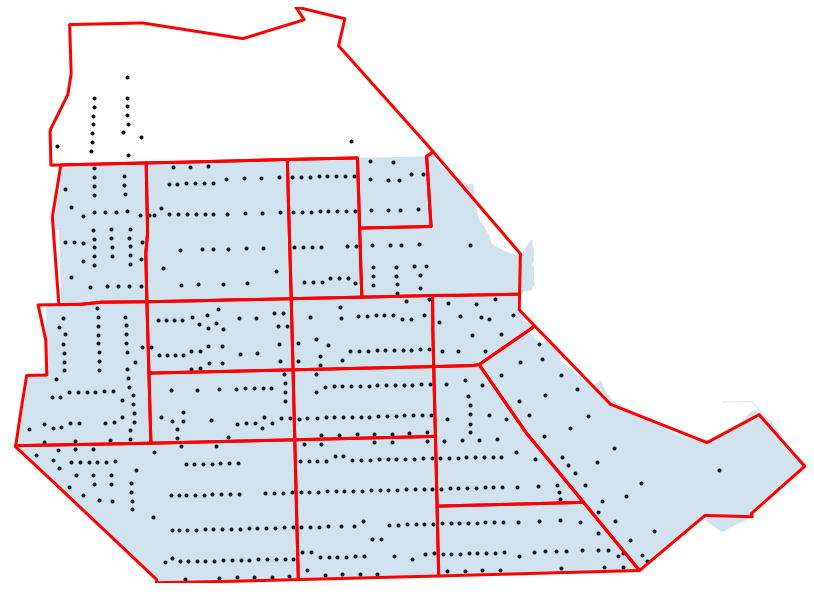

In [10]:
fig, ax = plt.subplots()

ss_tracts.boundary.plot(color = "red", ax = ax)
ss_blocks.plot(color = "k", markersize = 1, ax = ax)

gs([sa_ca_g]).plot(ax = ax, alpha = 0.2)

map_format(ax)

### Latencies, from SamKnows

In [11]:
sk = pd.read_csv("latency.csv")

In [12]:
from influxdb import InfluxDBClient

from netrc import netrc
user, _, passwd = netrc().authenticators("tiger-influx-r")

client = InfluxDBClient(host = "tigerteam.io", port = 9999,
                        username = user, password = passwd,
                        database = "netrics", ssl = True, verify_ssl = True)


In [13]:
query = "SELECT google_rtt_avg_ms FROM networks WHERE install = 'saxon';"
jetson = pd.DataFrame(client.query(query).get_points())
jetson.rename(columns = {"google_rtt_avg_ms" : "latency"}, inplace = True)

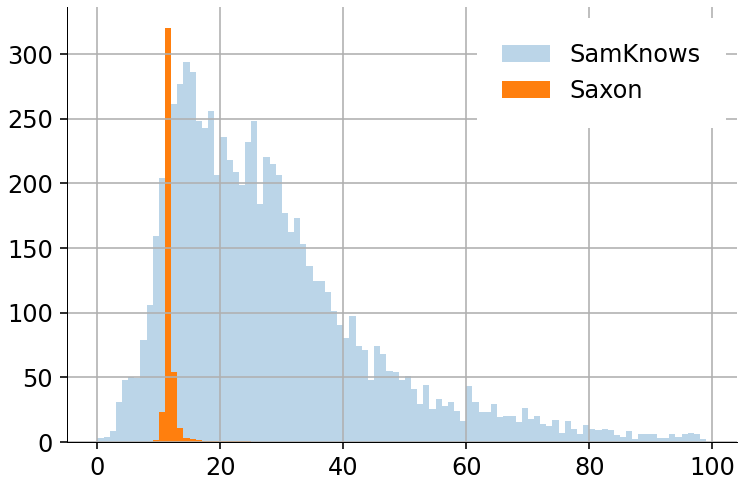

In [14]:
fig, ax = plt.subplots()

bins = np.arange(0, 100)

w = np.ones(jetson.shape[0]) / 60.
sk.rtt_mean.hist(bins = bins, ax = ax, alpha = 0.3, label = "SamKnows")
jetson.latency.hist(bins = bins, weights = w, ax = ax, alpha = 1, label = "Saxon")

ax.legend(frameon = True)

### Interpretations...

**South Shore basic counts**
* There are 16 tracts in South Shore.  Unfortunately, South Shore is one of two places in the city where community areas and tracts do not align well, as you can see above.  One tract reaches over into Woodlawn.
* There are 608 blocks.
* The population is a bit over 50k (The population totals above are not comparable: the tract population is from the most-recent-available 2019 5 year ACS, whereas the block population is from the most-recent-available 2010 Decennial Census.)

**Some thoughts on statistics**
* We are going to a fairly large number of metrics: latency, jitter, possibly consumption, etc.  Frankly, we do not have good data on what these distributions look like, though hopefully we'll get some soon, from Ookla.  We may also construct variables -- fraction of the time when latency exceeds _x_, that have more complicated distributions.
* Note that whereas Ookla sees one-off tests, we will have _much_ less variance per observation unit: we will have tens of thousands of measurements of latency, for instance, in each household.  So each mean will be very, very precise.
* We cannot really calculate power without knowing the population distribution.  We do not know the population distribution.  See above for a comparison of SamKnows latencies (average per device) with the latency to Google from my phone.  The national sample is completely unlike what we see in Chicago.  _If we saw variation among neighborhoods on a scale similar with the national variation it would be overwhelmingly obvious._
* At any rate, we must also decide what is "meaningful" in terms of the effect size / point estimates.  Some factoids for color:
  * Kyle sees 25 ms to Wikipedia, whereas I tend to see 32 ms.  I don't think this affects our quality of life, but there is a very consistent difference.  Does that reflect a different investment?  
  * On the other hand, sometimes his Amazon is clearly not local, and mine always is.
  * In Oberlin, things were all over the "map."  Nevertheless, the 10-20 ms extra latency had no impact on my life.
  * I am 12-14 hops from Google, whereas he is 10-12.  In Oberlin, it was 8-17.
  * Kyle sees a very significant discount of speedtest (TCP) to UDP (400 to 500 Mbps).  They are equal for me.
  * Max DNS latency is usually much better for him.
  
**A modest proposal**
* I would propose aiming, in the first place, to install 32 devices in South Shore -- 2 in each tract.  We could install an additional ~30 in neighborhood on the North Side.
* We may want to stratify by ISP, as SamKnows does, but I do not expect we will have the resources for it.